In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import interpolate
import time
import torch
import torch.nn.functional as F
from torch.optim import LBFGS

interp_mode = "bilinear"
align_corners = True


#n_grids = [12,16,20,24,28,32,36,40]
#n_grids = [12,16]
#n_grids = [6,10,14,20,30,40,50]
#n_grids = [6,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500,600,700,800,900,1000]
#n_grids = [10,20,30,40,50,60,70,80,90,100]
n_grids = [6,8,12,16,20,24,28,32,36,40,44,48]
#n_grids = [20]
#n_grids = [200]
theta_start = 0
theta_end = np.pi/2
r_start = 3
r_end = 4

a = 0.0
M = 1

errors = []
times = []
ii = 0


for n_grid in n_grids:
    print(n_grid)

    thetas = torch.linspace(theta_start,theta_end,steps=n_grid, dtype=torch.double)
    rs = torch.linspace(r_start,r_end,steps=n_grid, dtype=torch.double)
    theta_h = (theta_end - theta_start)/(n_grid-1)
    r_h  = (r_end - r_start)/(n_grid-1)

    RS, THETAS = torch.meshgrid(rs, thetas)
    # Transpose here is very important! Becareful of meshgrid and reshape stuff!
    #RS = torch.transpose(RS,0,1)
    #THETAS = torch.transpose(THETAS,0,1)
    z = torch.transpose(torch.stack([RS.reshape(-1,), THETAS.reshape(-1,)]),0,1)
    
    #print(z)

    # t' = t + f1(r,theta)
    def f1(f1_free, n_grid):
        # f1_free has shape (n_grid, n_grid-1).
        # Along theta, zero derivative at theta=pi/2
        f1_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f1_[:,:-1] = f1_free
        f1_[:,-1] = f1_free[:,-1]
        return f1_

    # r' = r + f2(r,theta)
    def f2(f2_free, n_grid):
        # f2_free has shape (n_grid, n_grid-1).
        # Along theta, zero derivative at theta=pi/2
        f2_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f2_[:,:-1] = f2_free
        f2_[:,-1] = f2_free[:,-1]
        return f2_

    # theta' = theta + f3(r,theta)
    def f3(f3_free, n_grid):
        # f3_free has shape (n_grid, n_grid-2)
        # Along theta, zero at theta=0 and theta=pi/2
        f3_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f3_[:,1:-1] = f3_free
        return f3_

    # phi' = phi + f4(r,theta)
    def f4(f4_free, n_grid):
        # f4_free has shape (n_grid, n_grid-1).
        # Along theta, zero derivative at theta=pi/2
        f4_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f4_[:,:-1] = f4_free
        f4_[:,-1] = f4_free[:,-1]
        return f4_
    
    
    def interp_free(f_free, n_grid, mode="0"):
        n_grid_old = f_free.shape[0]
        if mode == "0":
            f_ = f1(f_free, n_grid_old)
        else:
            f_ = f3(f_free, n_grid_old)
        f_free_std = f_.unsqueeze(dim=0).unsqueeze(dim=0)
        if mode == "0":
            f_free_new = F.interpolate(f_free_std, size=(n_grid,n_grid), mode=interp_mode, align_corners=align_corners)[0,0,:,:-1]
        else:
            f_free_new = F.interpolate(f_free_std, size=(n_grid,n_grid), mode=interp_mode, align_corners=align_corners)[0,0,:,1:-1]
        return f_free_new#torch.transpose(f_free_new,0,1)#

    def interp_free_test(f_free, n_grid, mode="0"):
        if mode == "0":
            f_ = f1(f_free, n_grid)
        else:
            f_ = f3(f_free, n_grid)
        f_free_std = f_.unsqueeze(dim=0).unsqueeze(dim=0)
        if mode == "0":
            f_free_new = F.interpolate(f_free_std, size=(2*n_grid-1,2*n_grid-1), mode=interp_mode, align_corners=align_corners)[0,0,1:-1:2,1:-3:2]
        else:
            f_free_new = F.interpolate(f_free_std, size=(2*n_grid-1,2*n_grid-1), mode=interp_mode, align_corners=align_corners)[0,0,1:-1:2,3:-3:2]
        return f_free_new#torch.transpose(f_free_new,0,1)#

    def decompose_free(f_free, n_grid):
        f1_free = f_free[:,:n_grid-1]
        f2_free = f_free[:,n_grid-1:2*n_grid-2]
        f3_free = f_free[:,2*n_grid-2:3*n_grid-4]
        f4_free = f_free[:,3*n_grid-4:4*n_grid-5]
        return (f1_free,f2_free,f3_free,f4_free)

    def compose_free(f1_free,f2_free,f3_free,f4_free):
        return torch.cat([f1_free, f2_free, f3_free, f4_free], dim=1)

    def interp_f_free(f_free, n_grid, n_grid_old):
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid_old)
        f1_free_new = interp_free(f1_free, n_grid, mode="0")
        f2_free_new = interp_free(f2_free, n_grid, mode="0")
        f3_free_new = interp_free(f3_free, n_grid, mode="1")
        f4_free_new = interp_free(f4_free, n_grid, mode="0")
        f_free_new = compose_free(f1_free_new, f2_free_new, f3_free_new, f4_free_new)
        return f_free_new


    def interp_f_free_test(f_free, n_grid):
        f_free = f_free.reshape(n_grid, 4*n_grid-5)
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid)
        f1_free_new = interp_free_test(f1_free, n_grid, mode="0")
        f2_free_new = interp_free_test(f2_free, n_grid, mode="0")
        f3_free_new = interp_free_test(f3_free, n_grid, mode="1")
        f4_free_new = interp_free_test(f4_free, n_grid, mode="0")
        #print(f1_free_new.shape, f2_free_new.shape, f3_free_new.shape, f4_free_new.shape)
        f_free_new = compose_free(f1_free_new, f2_free_new, f3_free_new, f4_free_new)
        return f_free_new


    def r_derivative(f, n_grid):
        f_aug = torch.zeros(n_grid+2,n_grid,dtype=torch.double)
        f_aug[1:-1] = f
        f_aug[0] = 2*f[0] - f[1]
        f_aug[-1] = 2*f[-1] - f[-2]
        f_r = (f_aug[2:] - f_aug[:-2])/(2*r_h)
        return f_r

    def theta_derivative(f, n_grid):
        f_aug = torch.zeros(n_grid,n_grid+2,dtype=torch.double)
        f_aug[:,1:-1] = f
        f_aug[:,0] = 2*f[:,0] - f[:,1]
        f_aug[:,-1] = 2*f[:,-1] - f[:,-2]
        f_theta = (f_aug[:,2:] - f_aug[:,:-2])/(2*theta_h)
        return f_theta

    def w(f1,f2,f3,f4, n_grid):
        f1_r = r_derivative(f1, n_grid).reshape(-1,)
        f2_r = r_derivative(f2, n_grid).reshape(-1,)
        f3_r = r_derivative(f3, n_grid).reshape(-1,)
        f4_r = r_derivative(f4, n_grid).reshape(-1,)
        f1_theta = theta_derivative(f1, n_grid).reshape(-1,)
        f2_theta = theta_derivative(f2, n_grid).reshape(-1,)
        f3_theta = theta_derivative(f3, n_grid).reshape(-1,)
        f4_theta = theta_derivative(f4, n_grid).reshape(-1,)
        ones = torch.ones(f1_r.shape[0], dtype=torch.double)

        stack1 = torch.stack([ones, f1_r, f1_theta, 0*ones])
        stack2 = torch.stack([0*ones, 1+f2_r, f2_theta, 0*ones])
        stack3 = torch.stack([0*ones, f3_r, 1+f3_theta, 0*ones])
        stack4 = torch.stack([0*ones, f4_r, f4_theta, ones])
        w_ = torch.stack([stack1, stack2, stack3, stack4])
        w_ = w_.permute(2,0,1)
        return w_

    def w_inv_invt(w):
        w_inv = torch.linalg.inv(w)
        w_invt = w_inv.permute(0,2,1)
        return w_inv, w_invt

    def gp(g, w):
        w_inv, w_invt = w_inv_invt(w)
        gp_ = torch.matmul(torch.matmul(w_invt, g), w_inv)
        return gp_

    def zp(z, f2, f3):
        f2 = f2.reshape(-1,)
        f3 = f3.reshape(-1,)
        rp = z[:,0] + f2
        thetap = z[:,1] + f3
        zp_ = torch.transpose(torch.stack([rp, thetap]),0,1)
        return zp_

    def g(x_, a=0.0):
        r = x_[:,0]
        theta = x_[:,1]
        bs = x_.shape[0]
        Sigma = r**2 + a**2*np.cos(theta)**2
        Delta = r**2 - 2*M*r + a**2
        one = torch.ones(bs, dtype=torch.double)
        g01 = g02 = g10 = g12 = g13 = g20 = g21 = g23 = g31 = g32 = 0*one
        g00 = -(1-2*M*r/Sigma)
        g03 = g30 = -2*M*a*r*torch.sin(theta)**2/Sigma
        g11 = Sigma/Delta
        g22 = Sigma
        g33 = (r**2+a**2+2*M*a**2*r*torch.sin(theta)**2/Sigma)*torch.sin(theta)**2
        #print(g00.shape, g01.shape, g02.shape, g03.shape)
        stack1 = torch.stack([g00, g01, g02, g03])
        stack2 = torch.stack([g10, g11, g12, g13])
        stack3 = torch.stack([g20, g21, g22, g23])
        stack4 = torch.stack([g30, g31, g32, g33])
        gs = torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
        return gs

    def gp_space_target(zp):
        bs = zp.shape[0]
        one = torch.ones(bs, dtype=torch.double)
        g11 = one
        g12 = g13 = g21 = g23 = g31 = g32 = 0*one
        g22 = zp[:,0]**2
        g33 = zp[:,0]**2*torch.sin(zp[:,1])**2
        stack1 = torch.stack([g11,g12,g13])
        stack2 = torch.stack([g21,g22,g23])
        stack3 = torch.stack([g31,g32,g33])
        gs = torch.stack([stack1, stack2, stack3]).permute(2,0,1)
        return gs

    def error(f_free, mode="train"):
        f_free = f_free.reshape(n_grid, 4*n_grid-5)
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid)
        f1_ = f1(f1_free, n_grid)
        f2_ = f2(f2_free, n_grid)
        f3_ = f3(f3_free, n_grid)
        f4_ = f4(f4_free, n_grid)
        g_ = g(z, a=a)
        w_ = w(f1_,f2_,f3_,f4_, n_grid)
        zp_ = zp(z,f2_,f3_)
        gp_space = gp(g_, w_)[:,1:,1:].reshape(n_grid,n_grid,3,3)
        #print(gp_space): inconsistent here
        
        gp_space_target_ = gp_space_target(zp_).reshape(n_grid,n_grid,3,3)
        if mode == "train":
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,:]**2)
        else:
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,1:-1]**2)
        return error_
    
    # Initialize next grid with the former solution
    if ii == 0:
    #if True:
        f_free = torch.zeros((n_grid,4*n_grid-5), dtype=torch.double)
        #f_free[:,:n_grid-1] = 1*M*(2*np.sqrt(rs/(2*M)) + 0.5*np.log((np.sqrt(rs/(2*M))-1)/(np.sqrt(rs/(2*M))+1)))[:,np.newaxis]
        #f_free[:,:n_grid-1] = 2*M*(2*np.sqrt(rs/(2*M)) + 1*np.log((np.sqrt(rs/(2*M))-1)/(np.sqrt(rs/(2*M))+1)))[:,np.newaxis]
        #f_free[:,:n_grid-1] = - 2*M*(2*np.sqrt(rs/(2*M)) - 1*np.log((np.sqrt(rs/(2*M))-1)/(np.sqrt(rs/(2*M))+1)))[:,np.newaxis]
        f_free[:,:n_grid-1] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,:-1])
        f_free[:,n_grid-1:2*(n_grid-1)] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,:-1])
        f_free[:,2*(n_grid-1):3*n_grid-4] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,1:-1])
        f_free[:,3*n_grid-4:4*n_grid-5] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,:-1])
        f_free = f_free.reshape(-1,)
        f_free = torch.nn.Parameter(f_free, requires_grad=True)
        #print(f_free.shape)
    else:
        #best_free = torch.load('./results_grid/a_%.3f_grid_%d'%(1.0,50))
        #f_free_old = best_free.reshape(50, 4*50-5)
        #f_free = interp_f_free(f_free_old, n_grid, 50).reshape(-1,)
        f_free_old = best_free.reshape(n_grid_old, 4*n_grid_old-5)
        #print(f_free_old.shape)
        #print(n_grid, n_grid_old)
        f_free = interp_f_free(f_free_old, n_grid, n_grid_old).reshape(-1,)
        f_free = torch.nn.Parameter(f_free, requires_grad=True)
        #print(interp_f_free(f_free_old, n_grid, n_grid_old).shape)
    
    # "Testing"
    #rs_test, thetas_test = grid(n_grid)
    rs_test = (rs[1:] + rs[:-1])/2
    thetas_test = (thetas[1:] + thetas[:-1])/2
    f_free_test = interp_f_free_test(f_free, n_grid).reshape(-1,)
    #plt.matshow(f_free_test.reshape(n_grid-1,4*(n_grid-1)-5))
    RS_test, THETAS_test = torch.meshgrid(rs_test, thetas_test)
    # Transpose here is very important! Becareful of meshgrid and reshape stuff!
    #RS_test = torch.transpose(RS_test,0,1)
    #THETAS_test = torch.transpose(THETAS_test,0,1)
    z_test = torch.transpose(torch.stack([RS_test.reshape(-1,), THETAS_test.reshape(-1,)]),0,1)

    
    def error_test(f_free, mode="train"):
        #print(f_free.shape)
        f_free = f_free.reshape(n_grid-1, 4*(n_grid-1)-5)
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid-1)
        f1_ = f1(f1_free, n_grid-1)
        f2_ = f2(f2_free, n_grid-1)
        f3_ = f3(f3_free, n_grid-1)
        f4_ = f4(f4_free, n_grid-1)
        g_ = g(z_test, a=a)
        w_ = w(f1_,f2_,f3_,f4_, n_grid-1)
        zp_test = zp(z_test,f2_,f3_)
        gp_space = gp(g_, w_)[:,1:,1:].reshape(n_grid-1,n_grid-1,3,3)
        
        gp_space_target_ = gp_space_target(zp_test).reshape(n_grid-1,n_grid-1,3,3)
        if mode == "train":
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,:]**2)
        else:
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,1:-1]**2)
        return error_
    
    def error_all(f_free, mode="train"):
        f_free_test = interp_f_free_test(f_free, n_grid).reshape(-1,)
        #print(interp_f_free_test(f_free, n_grid).shape)
        return error(f_free, mode=mode) + error_test(f_free_test, mode=mode)
    
    
    # Test and Train at the same time
    start = time.time()
    #lr = 36/n_grid**2
    #opt = LBFGS({f_free}, lr=lr, max_iter=1000, max_eval=None, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=1000, line_search_fn='strong_wolfe')
    #opt = LBFGS({f_free}, lr=lr, max_iter=100, max_eval=None, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=1000)
    lr = 1e-2*(6/n_grid)**2
    opt = torch.optim.Adam({f_free}, lr=lr, eps=1e-8)
    
    epochs = 15000
    switch_epoch = 3000
    log = 100
    best_loss = 1e20
    losses = []
    for i in range(epochs):
        if (i+1) % switch_epoch == 0:
            for opt_param in opt.param_groups:
                lr = lr * 0.5
                opt_param['lr'] = lr
        
        def loss_closure():
            opt.zero_grad()
            loss = error_all(f_free, mode="train")
            loss.backward()
            return loss
        
        def loss_closure2():
            opt.zero_grad()
            loss = error_all(f_free, mode="evaluate")
            loss.backward()
            return loss
          # -------------------------------------------
        loss = loss_closure()
        #print("loss_0={}".format(loss.detach().numpy()))
        #loss2 = loss_closure2()
        opt.step(loss_closure)  # get loss, use to update wts
        #loss = loss_closure()
        if loss < best_loss:
            best_loss = loss
            #best_loss2 = loss2
            best_epoch = i
            best_free = f_free.clone()
        if i % log == 0:
            print("Epoch: {}".format(i) + " | " + "Loss: {}".format(loss.detach().numpy()))
        losses.append(loss.detach().numpy())
    end = time.time()
    print("time={}".format(end-start))
    times.append(end-start)
    errors.append(best_loss.detach().numpy())
    print("error={}".format(loss.detach().numpy()))
    print("best loss={}".format(best_loss.detach().numpy()))
    #print("best loss2={}".format(best_loss2.detach().numpy()))
    print("best epoch={}".format(best_epoch))
    #errors.append(error_all(f_free))
    ii = ii + 1
    n_grid_old = n_grid
    torch.save(best_free, './results_grid/params_grid_adam_lrdecay_randominit_seq_a_%.3f_n_%d'%(a,n_grid))
np.save('./results_grid/loss_grid_adam_lrdecay_randominit_seq_a_%.3f'%a, np.array([n_grids, errors, times]))
    

6
Epoch: 0 | Loss: 0.4259971752205497
Epoch: 100 | Loss: 0.0010220951537800549
Epoch: 200 | Loss: 0.000386381431285062
Epoch: 300 | Loss: 0.00023559945611537054
Epoch: 400 | Loss: 0.00017480753418804416
Epoch: 500 | Loss: 0.00011149080926617789
Epoch: 600 | Loss: 7.974568541872892e-05
Epoch: 700 | Loss: 7.727414620086964e-05
Epoch: 800 | Loss: 4.368148405515226e-05
Epoch: 900 | Loss: 0.0009706463485943603
Epoch: 1000 | Loss: 6.808741024383334e-05
Epoch: 1100 | Loss: 1.9355143280954128e-05
Epoch: 1200 | Loss: 2.009124764315332e-05
Epoch: 1300 | Loss: 1.3622711271797847e-05
Epoch: 1400 | Loss: 1.2209494131945523e-05
Epoch: 1500 | Loss: 6.174126286794492e-05
Epoch: 1600 | Loss: 8.706309322099841e-06
Epoch: 1700 | Loss: 6.167571481685147e-05
Epoch: 1800 | Loss: 1.1492488415443763e-05
Epoch: 1900 | Loss: 5.185750414804818e-06
Epoch: 2000 | Loss: 2.2512874759217465e-05
Epoch: 2100 | Loss: 0.00013139354260093255
Epoch: 2200 | Loss: 3.856046703693518e-06
Epoch: 2300 | Loss: 0.00015176224129924

Epoch: 4000 | Loss: 8.072010477880806e-07
Epoch: 4100 | Loss: 8.059639054115516e-07
Epoch: 4200 | Loss: 8.051352549229088e-07
Epoch: 4300 | Loss: 8.045726213209796e-07
Epoch: 4400 | Loss: 7.120686588708811e-05
Epoch: 4500 | Loss: 1.1160570556680997e-06
Epoch: 4600 | Loss: 3.0361662764188023e-05
Epoch: 4700 | Loss: 8.407849874667748e-07
Epoch: 4800 | Loss: 7.344512991717035e-06
Epoch: 4900 | Loss: 4.031712450653379e-05
Epoch: 5000 | Loss: 8.713271506344054e-07
Epoch: 5100 | Loss: 0.0001693732798070047
Epoch: 5200 | Loss: 9.178494091660141e-07
Epoch: 5300 | Loss: 7.652525659897891e-05
Epoch: 5400 | Loss: 2.0123215687766425e-06
Epoch: 5500 | Loss: 7.012201483067313e-06
Epoch: 5600 | Loss: 5.368034868060483e-05
Epoch: 5700 | Loss: 2.5268204688405805e-06
Epoch: 5800 | Loss: 4.0961747103670124e-05
Epoch: 5900 | Loss: 2.9779299312778983e-05
Epoch: 6000 | Loss: 9.019928679307516e-07
Epoch: 6100 | Loss: 8.505190602332606e-07
Epoch: 6200 | Loss: 8.272662573923831e-07
Epoch: 6300 | Loss: 8.162327

Epoch: 8100 | Loss: 2.8280009014083164e-07
Epoch: 8200 | Loss: 3.34999838390543e-07
Epoch: 8300 | Loss: 1.1227612502622756e-06
Epoch: 8400 | Loss: 9.952784405124598e-07
Epoch: 8500 | Loss: 7.428046461745379e-07
Epoch: 8600 | Loss: 9.438216808968288e-07
Epoch: 8700 | Loss: 2.2342003510129035e-06
Epoch: 8800 | Loss: 6.681167379266848e-07
Epoch: 8900 | Loss: 7.6315727979941e-06
Epoch: 9000 | Loss: 2.179483145648834e-07
Epoch: 9100 | Loss: 2.1273863575133872e-07
Epoch: 9200 | Loss: 2.1221202583291154e-07
Epoch: 9300 | Loss: 2.1180494797832168e-07
Epoch: 9400 | Loss: 2.1148255132886361e-07
Epoch: 9500 | Loss: 2.1122607767626158e-07
Epoch: 9600 | Loss: 2.110213726746297e-07
Epoch: 9700 | Loss: 2.1085763692326827e-07
Epoch: 9800 | Loss: 2.107265387094408e-07
Epoch: 9900 | Loss: 2.1062157818897921e-07
Epoch: 10000 | Loss: 2.105376299145729e-07
Epoch: 10100 | Loss: 2.1047061242979418e-07
Epoch: 10200 | Loss: 2.1041724825512952e-07
Epoch: 10300 | Loss: 2.1037488796534878e-07
Epoch: 10400 | Loss:

Epoch: 12100 | Loss: 7.524211562564872e-08
Epoch: 12200 | Loss: 7.521991953703594e-08
Epoch: 12300 | Loss: 7.520745037686337e-08
Epoch: 12400 | Loss: 7.51958395796025e-08
Epoch: 12500 | Loss: 7.518503808244251e-08
Epoch: 12600 | Loss: 7.517500264076872e-08
Epoch: 12700 | Loss: 7.516569409497198e-08
Epoch: 12800 | Loss: 7.515707658692627e-08
Epoch: 12900 | Loss: 7.514911691806924e-08
Epoch: 13000 | Loss: 7.514178395135173e-08
Epoch: 13100 | Loss: 7.513504805353214e-08
Epoch: 13200 | Loss: 7.512888059592929e-08
Epoch: 13300 | Loss: 7.51232535320185e-08
Epoch: 13400 | Loss: 7.51181390654876e-08
Epoch: 13500 | Loss: 1.4250615458420266e-06
Epoch: 13600 | Loss: 7.541191682958357e-08
Epoch: 13700 | Loss: 7.515936532190837e-08
Epoch: 13800 | Loss: 8.479028075954183e-08
Epoch: 13900 | Loss: 8.631759443546172e-08
Epoch: 14000 | Loss: 9.992875003414265e-08
Epoch: 14100 | Loss: 9.670283760327837e-08
Epoch: 14200 | Loss: 2.563291259643779e-07
Epoch: 14300 | Loss: 1.87375064677553e-07
Epoch: 14400 |

Epoch: 900 | Loss: 2.9731477066367634e-06
Epoch: 1000 | Loss: 1.6679337083689405e-06
Epoch: 1100 | Loss: 1.009009522730468e-06
Epoch: 1200 | Loss: 8.476894505239651e-06
Epoch: 1300 | Loss: 6.6115198953073815e-06
Epoch: 1400 | Loss: 1.2368963137300155e-05
Epoch: 1500 | Loss: 9.946266222424808e-06
Epoch: 1600 | Loss: 6.301936930616826e-05
Epoch: 1700 | Loss: 8.62238500788631e-06
Epoch: 1800 | Loss: 1.873197559307206e-05
Epoch: 1900 | Loss: 4.523007501268154e-06
Epoch: 2000 | Loss: 1.5935347865879063e-05
Epoch: 2100 | Loss: 7.340724197481482e-05
Epoch: 2200 | Loss: 1.0496607504314502e-05
Epoch: 2300 | Loss: 4.633869748299475e-06
Epoch: 2400 | Loss: 4.290535496461529e-06
Epoch: 2500 | Loss: 9.204414170607357e-05
Epoch: 2600 | Loss: 4.9036686158985575e-06
Epoch: 2700 | Loss: 3.871428081761528e-06
Epoch: 2800 | Loss: 9.756699791494455e-06
Epoch: 2900 | Loss: 6.49480511949791e-06
Epoch: 3000 | Loss: 1.990399569667032e-07
Epoch: 3100 | Loss: 3.2365918364843e-08
Epoch: 3200 | Loss: 2.8602719767

Epoch: 4900 | Loss: 9.36247288623441e-06
Epoch: 5000 | Loss: 2.1510336777682075e-06
Epoch: 5100 | Loss: 1.8145599143984712e-06
Epoch: 5200 | Loss: 6.34228641015494e-06
Epoch: 5300 | Loss: 1.2265808758165258e-06
Epoch: 5400 | Loss: 6.506023970961161e-06
Epoch: 5500 | Loss: 9.692036769248668e-07
Epoch: 5600 | Loss: 8.643507465970069e-07
Epoch: 5700 | Loss: 1.0428039121602116e-06
Epoch: 5800 | Loss: 2.144794145082862e-06
Epoch: 5900 | Loss: 1.3522710759473915e-06
Epoch: 6000 | Loss: 1.435400700733351e-08
Epoch: 6100 | Loss: 1.090196568203209e-08
Epoch: 6200 | Loss: 1.0703635966245847e-08
Epoch: 6300 | Loss: 1.0531195954801637e-08
Epoch: 6400 | Loss: 1.0379357328320106e-08
Epoch: 6500 | Loss: 1.0245414941328893e-08
Epoch: 6600 | Loss: 1.0127160701530134e-08
Epoch: 6700 | Loss: 1.002271313914477e-08
Epoch: 6800 | Loss: 9.930445766124628e-09
Epoch: 6900 | Loss: 9.848941604750287e-09
Epoch: 7000 | Loss: 9.776959729791648e-09
Epoch: 7100 | Loss: 9.713409058155782e-09
Epoch: 7200 | Loss: 9.6573

Epoch: 9000 | Loss: 9.668834498492204e-09
Epoch: 9100 | Loss: 5.744605324068111e-09
Epoch: 9200 | Loss: 5.732284194091306e-09
Epoch: 9300 | Loss: 5.72226753562752e-09
Epoch: 9400 | Loss: 5.712549810628165e-09
Epoch: 9500 | Loss: 5.703135344062722e-09
Epoch: 9600 | Loss: 5.694033389268993e-09
Epoch: 9700 | Loss: 5.685252986060887e-09
Epoch: 9800 | Loss: 5.676801934967654e-09
Epoch: 9900 | Loss: 5.668686497410297e-09
Epoch: 10000 | Loss: 5.660911287921016e-09
Epoch: 10100 | Loss: 5.653479240673964e-09
Epoch: 10200 | Loss: 5.646391615628701e-09
Epoch: 10300 | Loss: 5.639648031680835e-09
Epoch: 10400 | Loss: 5.633246521294844e-09
Epoch: 10500 | Loss: 3.6216348335007674e-06
Epoch: 10600 | Loss: 6.500724273405167e-09
Epoch: 10700 | Loss: 1.5944366820546384e-08
Epoch: 10800 | Loss: 5.718203341631533e-08
Epoch: 10900 | Loss: 8.808568314805632e-08
Epoch: 11000 | Loss: 7.02462450361413e-08
Epoch: 11100 | Loss: 2.199867745474185e-07
Epoch: 11200 | Loss: 1.572866460267565e-07
Epoch: 11300 | Loss: 

Epoch: 13000 | Loss: 3.5566312980019315e-09
Epoch: 13100 | Loss: 3.555506703377623e-09
Epoch: 13200 | Loss: 3.554390667392385e-09
Epoch: 13300 | Loss: 3.5532852832891992e-09
Epoch: 13400 | Loss: 3.5521926159316883e-09
Epoch: 13500 | Loss: 4.131638218012273e-07
Epoch: 13600 | Loss: 2.9166974063393396e-08
Epoch: 13700 | Loss: 7.031268802881179e-09
Epoch: 13800 | Loss: 2.0513981468523498e-08
Epoch: 13900 | Loss: 1.2722713607844282e-08
Epoch: 14000 | Loss: 7.901345030633014e-08
Epoch: 14100 | Loss: 1.503623259118334e-08
Epoch: 14200 | Loss: 1.831084181423887e-08
Epoch: 14300 | Loss: 8.244793552728358e-08
Epoch: 14400 | Loss: 8.617031520713679e-08
Epoch: 14500 | Loss: 3.451337928501458e-08
Epoch: 14600 | Loss: 2.1650861232846252e-08
Epoch: 14700 | Loss: 1.3623406217975306e-08
Epoch: 14800 | Loss: 5.975885404020209e-08
Epoch: 14900 | Loss: 1.1808896731057142e-08
time=252.57641220092773
error=1.5146471349736086e-08
best loss=3.5515073250314443e-09
best epoch=13465
40
Epoch: 0 | Loss: 9.099542

Epoch: 1800 | Loss: 5.856962167300226e-06
Epoch: 1900 | Loss: 1.1634020408295594e-05
Epoch: 2000 | Loss: 5.32806725580723e-06
Epoch: 2100 | Loss: 3.269962482553305e-06
Epoch: 2200 | Loss: 4.449632815625136e-06
Epoch: 2300 | Loss: 9.285867533068818e-06
Epoch: 2400 | Loss: 5.07186314029124e-06
Epoch: 2500 | Loss: 6.163627900622066e-06
Epoch: 2600 | Loss: 6.824997663642962e-06
Epoch: 2700 | Loss: 5.484474640693452e-06
Epoch: 2800 | Loss: 4.749383076332592e-06
Epoch: 2900 | Loss: 7.4193837057665124e-06
Epoch: 3000 | Loss: 1.8304646011565104e-08
Epoch: 3100 | Loss: 3.6372801520561875e-09
Epoch: 3200 | Loss: 3.354857289036487e-09
Epoch: 3300 | Loss: 3.1552185647023117e-09
Epoch: 3400 | Loss: 2.980661319959576e-09
Epoch: 3500 | Loss: 2.8272608452373586e-09
Epoch: 3600 | Loss: 2.69203704793758e-09
Epoch: 3700 | Loss: 2.572558174755265e-09
Epoch: 3800 | Loss: 2.4667916620709024e-09
Epoch: 3900 | Loss: 2.3730178725923675e-09
Epoch: 4000 | Loss: 2.2897700133960424e-09
Epoch: 4100 | Loss: 2.215788

Epoch: 5800 | Loss: 1.023367017343141e-06
Epoch: 5900 | Loss: 6.861684214552805e-07
Epoch: 6000 | Loss: 1.0733833135343019e-08
Epoch: 6100 | Loss: 1.4910172680514922e-09
Epoch: 6200 | Loss: 1.4444031456468209e-09
Epoch: 6300 | Loss: 1.4265038096591377e-09
Epoch: 6400 | Loss: 1.4094024571592677e-09
Epoch: 6500 | Loss: 1.3930623248526864e-09
Epoch: 6600 | Loss: 1.3774682988112357e-09
Epoch: 6700 | Loss: 1.362608935663307e-09
Epoch: 6800 | Loss: 1.3484727134938838e-09
Epoch: 6900 | Loss: 1.335047054037453e-09
Epoch: 7000 | Loss: 1.3223180640790742e-09
Epoch: 7100 | Loss: 1.3102705076264266e-09
Epoch: 7200 | Loss: 1.2988878674907285e-09
Epoch: 7300 | Loss: 1.288152446275347e-09
Epoch: 7400 | Loss: 1.2780454855394103e-09
Epoch: 7500 | Loss: 2.904378018292307e-06
Epoch: 7600 | Loss: 3.1021973936751816e-07
Epoch: 7700 | Loss: 2.1636280328659803e-07
Epoch: 7800 | Loss: 1.4907143408488007e-07
Epoch: 7900 | Loss: 3.5568960975332293e-07
Epoch: 8000 | Loss: 1.9668734326630331e-07
Epoch: 8100 | Los

In [6]:
np.load('./results_grid/loss_grid_adam_lrdecay_randominit_seq_a_%.3f.npy'%a)

array([[6.00000000e+00, 8.00000000e+00, 1.20000000e+01, 1.60000000e+01,
        2.00000000e+01, 2.40000000e+01, 2.80000000e+01, 3.20000000e+01,
        3.60000000e+01, 4.00000000e+01, 4.40000000e+01, 4.80000000e+01],
       [1.71634783e-06, 8.02587614e-07, 2.10240038e-07, 7.51147534e-08,
        3.29811337e-08, 1.66479538e-08, 9.28198940e-09, 5.57837818e-09,
        3.55150733e-09, 2.36861268e-09, 1.64194801e-09, 1.17251696e-09],
       [1.83241197e+02, 1.78816741e+02, 1.90186091e+02, 1.92705887e+02,
        1.97709799e+02, 2.16186500e+02, 2.24539347e+02, 2.41020670e+02,
        2.52576412e+02, 2.69624580e+02, 2.82167291e+02, 3.04584208e+02]])

Text(0, 0.5, 'error')

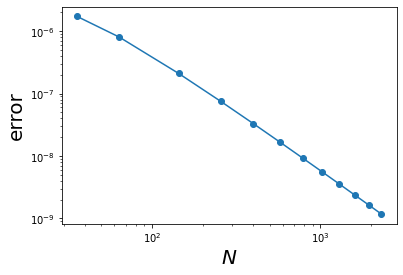

In [7]:
n_grids = np.array(n_grids)
#n_params = (4*n_grids-5)*n_grids
n_params = n_grids**2
#n_params = (n_grids-1)**2
plt.plot(n_params, errors, marker="o")
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-8,10e-5)
plt.xlabel(r"$N$",fontsize=20)
plt.ylabel("error",fontsize=20)

In [231]:
start_id = -6
end_id = -1

(np.log(errors[start_id]) - np.log(errors[end_id]))/(np.log(n_params[start_id])-np.log(n_params[end_id]))

-1.9201069227039909

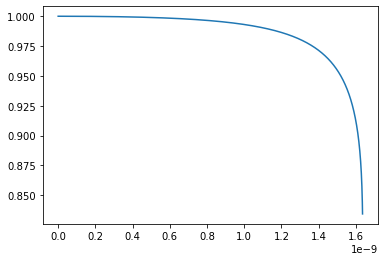

In [235]:
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy

start_id = -6
end_id = -1
loss_w = errors[start_id:end_id]
log_ws = np.log(n_params[start_id:end_id])
log_loss = np.log(errors[start_id:end_id])

reg = LinearRegression().fit(log_ws[:,np.newaxis], log_loss)
eps_max = np.min(loss_w)*0.999

num_sweep = 10001
eps0_sweep = np.linspace(0, eps_max, num=num_sweep)
scores = []

for i in range(num_sweep):
    score = np.abs(scipy.stats.pearsonr(log_ws, np.log(loss_w-eps0_sweep[i]))[0])
    scores.append(score)
    
plt.plot(eps0_sweep, scores)

In [236]:
max_id = np.argmax(scores)
eps0 = eps0_sweep[max_id]
reg.fit(log_ws[:,np.newaxis], np.log(loss_w-eps0))
alpha = reg.coef_[0]
A = np.e**reg.intercept_
print(max_id)
print(eps0)
print(alpha)
print(A)
#[eps0, A, alpha]

0
0.0
-1.9184066707629372
0.0033148606783546743


In [237]:
from scipy.optimize import minimize

def f(x):
    eps0 = x[0]
    A = x[1]
    alpha = x[2]
    return np.mean((loss_w-(A*n_params[start_id:end_id]**alpha+eps0))**2)

x0 = np.array([eps0, A, alpha])
sol = minimize(f, x0, tol=1e-32, options={'gtol':1e-30})
sol

      fun: 5.549117469329293e-23
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([1.49027668e-08, 9.45245568e-18, 2.01377313e-19])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 236
      nit: 0
     njev: 56
   status: 2
  success: False
        x: array([ 0.        ,  0.00331486, -1.91840667])